# Banking dataset with a `pymc` model

<div class="alert alert-warning">

Warning

This example is in-progress! Further elaboration and explanation will follow soon.

</div>

This notebook analyses historic data on banking closures from [Richardson & Troost (2009)](http://masteringmetrics.com/wp-content/uploads/2015/02/Richardson_Troost_2009_JPE.pdf) and used as a case study for a difference in differences analysis in the [Mastering Metrics](http://www.masteringmetrics.com) book. Here, we replicate this analysis, but using Bayesian inference.

In [1]:
import arviz as az
import pandas as pd

import causalpy as cp

In [2]:
%load_ext autoreload
%autoreload 2
# %config InlineBackend.figure_format = 'svg'

## Load data

The raw dataset has a `date` columns which is just some uninterpretable number. All we need for our analysis is the `year` column. We also have columns `bib6`, `bio6`, `bib8`, `bio8`. We know that the `6` and `8` represent the 6th and 8th Federal Reserve districts, respectively. I assume `bib` means "banks in business", so I'll discard the `bib*` columns. The data is at daily resolution, but we will convert this to yearly resolution. And from what I can tell from Figure 5.2 of the [Mastering Metrics](http://www.masteringmetrics.com) book, they seem to present the _median_ number of banks open per year. Let's load the data up and do those steps.

In [3]:
df = (
    cp.load_data("banks")
    # just keep columns we want
    .filter(items=["bib6", "bib8", "year"])
    # rename to meaningful variables
    .rename(columns={"bib6": "Sixth District", "bib8": "Eighth District"})
    # reduce from daily resolution to examine median banks open by year
    .groupby("year").median()
)

treatment_time = 1930.5

In [4]:
# SET TREATMENT TIME TO ZERO =========
df.index = df.index - treatment_time
treatment_time = 0
# ====================================
df

,Sixth District,Eighth District
year,,
-1.5,141.0,170.0
-0.5,135.0,165.0
0.5,121.0,132.0
1.5,113.0,120.0
2.5,102.0,111.0
3.5,102.0,110.0


Let's visualise what we have. This matches up exactly with Figure 5.2 of the [Mastering Metrics](http://www.masteringmetrics.com) book.

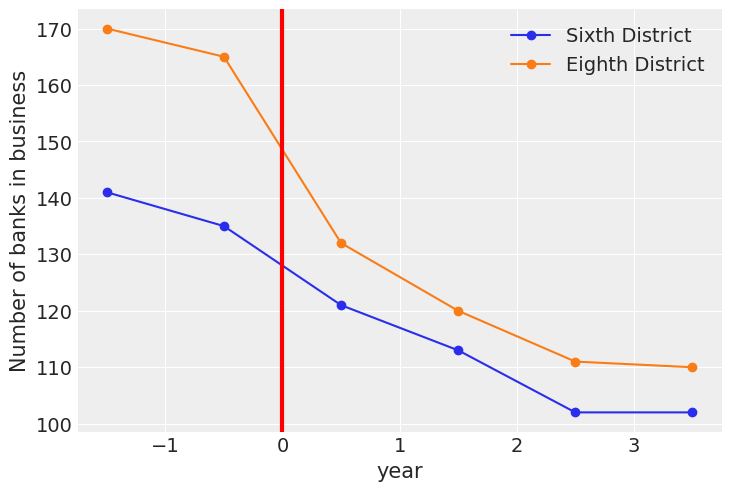

In [5]:
ax = df[["Sixth District", "Eighth District"]].plot(style="o-")
ax.set(ylabel="Number of banks in business")
ax.axvline(x=treatment_time, c="r", lw=3, label="intervention");

Just a few more final processing steps to make the data amenable to analysis. We will convert from wide form into long form. Then we will add a new column `treated` which indicates the observations where treatment has taken place.

In [6]:
df.reset_index(level=0, inplace=True)
df_long = pd.melt(
    df,
    id_vars=["year"],
    value_vars=["Sixth District", "Eighth District"],
    var_name="district",
    value_name="bib",
).sort_values("year")

# We also need to create a column called `unit` which labels each distinct unit. In our case we just have two treatment units (each district). So we can build a `unit` column from `district`.
df_long["unit"] = df_long["district"]

# We also need to create a `post_treatment` column to define times after the intervention.
df_long["post_treatment"] = df_long.year >= treatment_time
df_long

# Dummy coding for district
df_long = df_long.replace({"district": {"Sixth District": 1, "Eighth District": 0}})
df_long

,year,district,bib,unit,post_treatment
0,-1.5,1,141.0,Sixth District,False
6,-1.5,0,170.0,Eighth District,False
1,-0.5,1,135.0,Sixth District,False
7,-0.5,0,165.0,Eighth District,False
2,0.5,1,121.0,Sixth District,True
8,0.5,0,132.0,Eighth District,True
3,1.5,1,113.0,Sixth District,True
9,1.5,0,120.0,Eighth District,True
4,2.5,1,102.0,Sixth District,True
10,2.5,0,111.0,Eighth District,True


## Analysis 1

First we'll do an analysis just looking at data from 1930 and 1931. This way we just have a single pre-intervention and a single post-intervention measurement.

In [7]:
result1 = cp.pymc_experiments.DifferenceInDifferences(
    # df_long[df_long.year.isin([1930, 1931])],
    df_long[df_long.year.isin([-0.5, 0.5])],
    formula="bib ~ 1 + district * post_treatment",
    time_variable_name="year",
    group_variable_name="district",
    treated=1,
    untreated=0,
    model=cp.pymc_models.LinearRegression(sample_kwargs={"target_accept": 0.95}),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
/Users/benjamv/git/CausalPy/causalpy/pymc_experiments.py:366: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_x.iloc[:, i] = 0
Sampling: [y_hat]


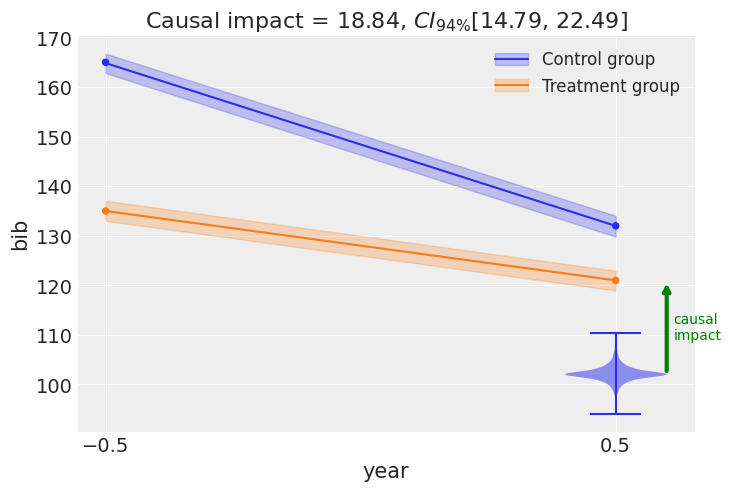

In [8]:
fig, ax = result1.plot();

In [9]:
result1.summary()

===========================Difference in Differences============================
Formula: bib ~ 1 + district * post_treatment

Results:
Causal impact = 18.84, $CI_{94\%}$[14.79, 22.49]
Model coefficients:
Intercept                     164.84, 94% HDI [162.60, 166.56]
post_treatment[T.True]        -32.84, 94% HDI [-35.34, -29.82]
district                      -29.83, 94% HDI [-32.46, -26.86]
district:post_treatment[T.True]18.84, 94% HDI [14.79, 22.49]
sigma                         0.83, 94% HDI [0.15, 2.14]


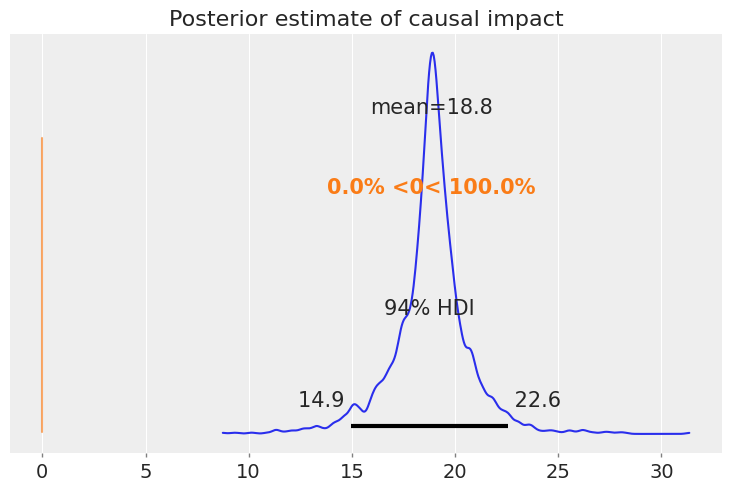

In [10]:
ax = az.plot_posterior(result1.causal_impact, ref_val=0, round_to=3)
ax.set(title="Posterior estimate of causal impact");

## Analysis 2

Now we'll do a difference in differences analysis of the full dataset.

In [11]:
result2 = cp.pymc_experiments.DifferenceInDifferences(
    df_long,
    formula="bib ~ 1 + year + district + post_treatment + district:post_treatment",
    time_variable_name="year",
    group_variable_name="district",
    treated=1,
    untreated=0,
    model=cp.pymc_models.LinearRegression(),
)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [beta, sigma, y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
/Users/benjamv/git/CausalPy/causalpy/pymc_experiments.py:366: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  new_x.iloc[:, i] = 0
Sampling: [y_hat]


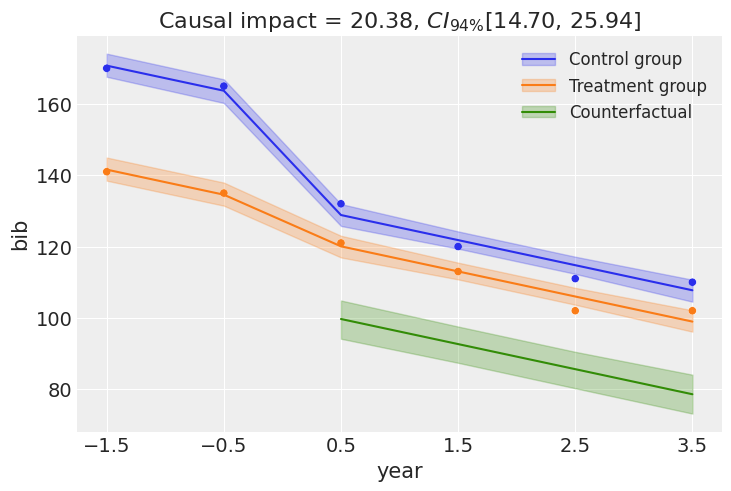

In [12]:
fig, ax = result2.plot();

In [13]:
result2.summary()

===========================Difference in Differences============================
Formula: bib ~ 1 + year + district + post_treatment + district:post_treatment

Results:
Causal impact = 20.38, $CI_{94\%}$[14.70, 25.94]
Model coefficients:
Intercept                     160.19, 94% HDI [156.63, 163.62]
post_treatment[T.True]        -27.83, 94% HDI [-33.59, -21.98]
year                          -7.04, 94% HDI [-8.35, -5.68]
district                      -29.17, 94% HDI [-33.72, -24.71]
district:post_treatment[T.True]20.38, 94% HDI [14.70, 25.94]
sigma                         2.37, 94% HDI [1.71, 3.23]


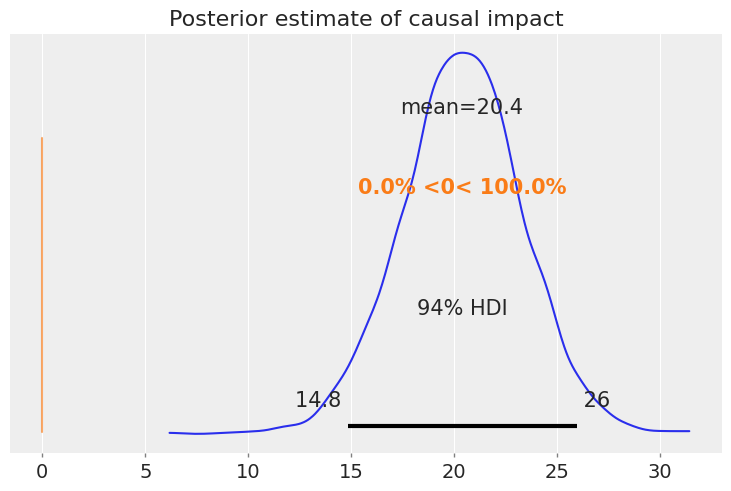

In [14]:
ax = az.plot_posterior(result2.causal_impact, ref_val=0, round_to=3)
ax.set(title="Posterior estimate of causal impact");